In [1]:
cd /content/drive/MyDrive/GenAI Project/

/content/drive/MyDrive/GenAI Project


In [2]:
import json

# with open('Dataset/Validation/mahabharata_questions.json', 'r') as f:
#     mahabharata_questions = json.load(f)

# with open('Dataset/Corpus/entities_speakers_verses.json', 'r') as f:
#     entities_speakers_verses = json.load(f)

# with open('Dataset/Corpus/verses.json', 'r') as f:
#     verses = json.load(f)

with open('Dataset/Corpus/chapters.json', 'r') as f:
    chapters = json.load(f)

with open('Dataset/Corpus/entities_kb.json', 'r') as f:
    entities_kb = json.load(f)

with open('Dataset/Corpus/chapter_entities_speakers.json', 'r') as f:
    chapter_entities_speakers = json.load(f)

with open('Dataset/Corpus/chapter_entities.json', 'r') as f:
    chapter_entities = json.load(f)


In [3]:
def parse_id(entity):
  return entity.split('-')[0]

def parse_name(entity):
  return entity.split('--')[-1]

entity_set = {}

for ch, data in chapter_entities.items():
  for entity, freq in data.items():
    entity_set[parse_id(entity)] = parse_name(entity)

ch_entities = {}
for ch, data in chapter_entities.items():
  ch_entities[ch] = {}
  for entity, freq in data.items():
    ch_entities[ch][parse_id(entity)] = freq

In [ ]:
with open('Dataset/Corpus/chapter_entity_ids.json', 'w') as f:
    json.dump(ch_entities, f, indent=2)

### PoC

In [ ]:
import math
from collections import defaultdict, Counter
import networkx as nx


# -----------------------------------------------------------
# build graph (no speakers, uses entity frequency)
# -----------------------------------------------------------

def build_entity_graph(chapter_entity_freq, beta=0.5):
    """
    chapter_entity_freq: dict
        { "ch_id": {"entity_id": freq, ...}, ... }
    beta: 0–1, controls how strong the IDF penalty is (lower = softer)
    """
    G = nx.Graph()
    freq = Counter()

    # 1. document frequency: in how many chapters an entity appears
    for ch, ents in chapter_entity_freq.items():
        for e in ents:
            freq[e] += 1

    N = len(chapter_entity_freq)

    # 2. add edges based on co-occurrence
    for ch, ents in chapter_entity_freq.items():
        items = list(ents.items())  # [(entity, count), ...]
        for i in range(len(items)):
            e1, c1 = items[i]
            for j in range(i + 1, len(items)):
                e2, c2 = items[j]
                f1 = freq.get(e1, 1)
                f2 = freq.get(e2, 1)

                # softened IDF penalty
                idf = (1 / (1 + math.log(f1))) ** 6 * (1 / (1 + math.log(f2))) ** 2
                idf = max(idf, 1e-4)  # avoid too tiny


                # co-occurrence strength based on local frequency product
                co_strength = (c1 * c2) ** 0.5  # geometric mean to smooth

                weight = idf * co_strength
                prev = G.get_edge_data(e1, e2, {"weight": 0})["weight"]
                G.add_edge(e1, e2, weight=prev + weight)

    return G


# -----------------------------------------------------------
# diffusion
# -----------------------------------------------------------

def quick_diffusion(G, seeds, steps=2, alpha=0.85):
    """Fast truncated diffusion from seed nodes"""
    act = defaultdict(float)
    frontier = defaultdict(float, {s: 1 / len(seeds) for s in seeds if s in G})

    for _ in range(steps):
        new_frontier = defaultdict(float)
        for node, val in frontier.items():
            nbrs = G[node]
            if not nbrs:
                continue
            tot_w = sum(d["weight"] for d in nbrs.values())
            for nbr, attrs in nbrs.items():
                new_frontier[nbr] += alpha * val * (attrs["weight"] / tot_w)
        for s in seeds:
            new_frontier[s] += (1 - alpha) / len(seeds)
        for k, v in new_frontier.items():
            act[k] += v
        frontier = new_frontier
    return act


# -----------------------------------------------------------
# chapter-level scoring
# -----------------------------------------------------------

def chapter_scores_from_graph(G, chapter_entity_freq, query_entity_ids, steps=2, alpha=0.85, top_k=10):
    """
    Compute graph-based relevance scores for each chapter.
    query_entity_ids: e.g. ["e4777", "e1499"]
    Matches partial IDs automatically.
    """
    # expand query IDs to match full node names
    expanded_queries = []
    for qid in query_entity_ids:
        expanded_queries.extend([n for n in G.nodes if n.startswith(qid)])

    if not expanded_queries:
        print("⚠️ No matching query entities found.")
        return []

    activation = quick_diffusion(G, expanded_queries, steps=steps, alpha=alpha)

    scores = {}
    for ch, ents in chapter_entity_freq.items():
        vals = []
        for e, c in ents.items():
            if e in activation:
                vals.append(activation[e] * c)  # weight by local freq
        scores[ch] = sum(vals) / (sum(ents.values()) or 1)

    ranked = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    return ranked[:top_k]


# -----------------------------------------------------------
# example usage
# -----------------------------------------------------------



In [ ]:
chapter_entities

{'1.1': {'e12207-person--vishnu': 5,
  'e4679-person--itihasa': 1,
  'e7587-person--nara': 2,
  'e9540-person--sarasvati': 1,
  'e2579-person--shaunaka': 1,
  'e7498-person--naimisha': 2,
  'e8267-misc--pauranika': 1,
  'e9817-person--sauti': 11,
  'e11327-person--vaishampayana': 4,
  'e4777-person--janamejaya': 3,
  'e6721-misc--mahabharata': 16,
  'e6276-location--kurukshetra': 1,
  'e6239-person--kuru': 3,
  'e7969-person--pandava': 15,
  'e1743-person--brahman': 5,
  'e8769-misc--purana': 9,
  'e10362-person--sura': 2,
  'e1782-person--brahmarshi': 2,
  'e11773-misc--veda': 13,
  'e12416-person--vyasa': 9,
  'e1697-person--brahma': 1,
  'e4679-misc--itihasa': 5,
  'e9365-misc--samhita': 1,
  'e4618-person--indra': 6,
  'e5907-person--krrishna': 23,
  'e8806-person--purusha': 2,
  'e12635-misc--yuga': 4,
  'e2661-person--shiva': 3,
  'e11959-person--vishvedevah': 1,
  'e123-person--ashvin': 1,
  'e1741-person--brahman': 9,
  'e177-person--aditya': 1,
  'e3015-person--daksha': 1,
  '

In [ ]:
if __name__ == "__main__":
    chapter_entity_freq = {
        "1.1.9": {
            "e11327-person--vyāsa": 4,
            "e4777-person--janamejaya": 3,
            "e6721-misc--mahābhārata": 1,
        },
        "1.1.10": {"e6276-location--kurukṣetra": 2},
        "1.1.11": {"e4777-person--janamejaya": 5, "e11327-person--vyāsa": 2},
    }

    G = build_entity_graph(chapter_entity_freq, beta=0.5)
    query_entities = ["e4777"]  # short-form query

    ranked = chapter_scores_from_graph(G, chapter_entity_freq, query_entities, steps=3, alpha=0.85, top_k=5)

    print("Top relevant chapters:")
    for ch, sc in ranked:
        print(f"{ch}\t{sc:.4f}")


Top relevant chapters:
1.1.11	1.1682
1.1.9	1.1431
1.1.10	0.0000


In [ ]:
G = build_entity_graph(chapter_entities)

In [ ]:
query_entities = ['e802', 'e1499']
ranked = chapter_scores_from_graph(G, chapter_entities, query_entities, steps=3, alpha=0.85, top_k=5)

print("Top relevant chapters (graph-based):")
for ch, sc in ranked:
    print(f"{ch}\t{sc:.4f}")


Top relevant chapters (graph-based):
2.8	0.0221
13.28	0.0030
13.27	0.0020
3.196	0.0019
13.32	0.0017


In [ ]:
print(chapters['2.8'])

Narada said O Yudhishthira, I shall now describe the assembly-hall of Yama, the son of Vaivasvata. O son of Pritha, it was built by Vishvakarma; hear all about it. 
O king, that effulgent Sabha covers an area of one hundred Yojanas. O son of Pandu, it possesses the splendour of the sun; it yields every thing that one may desire to have from it. It is neither very cold nor very hot. It delights the heart. 
There is no grief, and no decrepitude, no hunger, no thirst; nor there was any thing disagreeable, nor there was any kind of wretchedness of distress. There can be no fatigue or any kind of evil-feelings in that Sabha. 
O chastiser of foes, every object of desire, celestials or human, is to be found in that hall; all kinds of enjoyable articles as also sweet, juicy, agreeable and delicious things that are likeable, suckable or drinkable are all there in profusion. The garlands that are there are of the most delicious fragrance, and the trees that stand (around it) yield whatever fruit

In [ ]:
print("Graph nodes:", list(G.nodes)[:20])  # peek first few

for q in query_entities:
    matches = [n for n in G.nodes if n.startswith(q)]
    print(q, "→", matches)


Graph nodes: ['e12207-person--vishnu', 'e4679-person--itihasa', 'e7587-person--nara', 'e9540-person--sarasvati', 'e2579-person--shaunaka', 'e7498-person--naimisha', 'e8267-misc--pauranika', 'e9817-person--sauti', 'e11327-person--vaishampayana', 'e4777-person--janamejaya', 'e6721-misc--mahabharata', 'e6276-location--kurukshetra', 'e6239-person--kuru', 'e7969-person--pandava', 'e1743-person--brahman', 'e8769-misc--purana', 'e10362-person--sura', 'e1782-person--brahmarshi', 'e11773-misc--veda', 'e12416-person--vyasa']
e802 → ['e802-person--arjuna']
e1499 → ['e1499-person--bhishma']


In [ ]:
print("No. of connected components:", nx.number_connected_components(G))
print("Largest component size:", len(max(nx.connected_components(G), key=len)))


No. of connected components: 1
Largest component size: 4695


In [ ]:
expanded_queries = []
for qid in query_entities:
        expanded_queries.extend([n for n in G.nodes if n.startswith(qid)])

In [ ]:
for e in expanded_queries:
    if e in G:
        print(f"\nTop neighbors of {e}:")
        for nbr, attrs in sorted(G[e].items(), key=lambda x: -x[1]['weight'])[:10]:
            print(f"  {nbr:<40} weight={attrs['weight']:.4f}")



Top neighbors of e802-person--arjuna:
  e10019-person--srri~njaya                weight=1.0000
  e10271-person--sumanas                   weight=1.0000
  e10325-person--sunitha                   weight=1.0000
  e10431-person--suratha                   weight=1.0000
  e10925-person--trigarta                  weight=1.0000
  e11000-person--trrinaka                  weight=1.0000
  e12342-person--vrrishasena               weight=1.0000
  e12392-person--vyashva                   weight=1.0000
  e2019-person--chaturashva                weight=1.0000
  e2456-person--sharabha                   weight=1.0000

Top neighbors of e1499-person--bhishma:
  e10019-person--srri~njaya                weight=1.0000
  e10271-person--sumanas                   weight=1.0000
  e10325-person--sunitha                   weight=1.0000
  e10431-person--suratha                   weight=1.0000
  e10925-person--trigarta                  weight=1.0000
  e11000-person--trrinaka                  weight=1.0000
  e12342

In [ ]:
edge_counts = Counter()
for ch, data in chapter_entities.items():
    ents = list(set(data.keys()))
    for i in range(len(ents)):
        for j in range(i+1, len(ents)):
            e1, e2 = sorted([ents[i], ents[j]])
            edge_counts[(e1, e2)] += 1

print("Most frequent edges:")
for (e1, e2), c in edge_counts.most_common(20):
    print(f"{e1} – {e2}: {c}")


Most frequent edges:
e12633-person--yudhishthira – e1497-person--bhishma: 555
e12633-person--yudhishthira – e4618-person--indra: 511
e12633-person--yudhishthira – e801-person--arjuna: 494
e12633-person--yudhishthira – e7969-person--pandava: 473
e3805-person--duryodhana – e7969-person--pandava: 460
e11327-person--vaishampayana – e12633-person--yudhishthira: 459
e7969-person--pandava – e801-person--arjuna: 451
e1454-person--bhima – e801-person--arjuna: 443
e5907-person--krrishna – e801-person--arjuna: 441
e12633-person--yudhishthira – e1454-person--bhima: 439
e3805-person--duryodhana – e801-person--arjuna: 435
e4618-person--indra – e801-person--arjuna: 432
e1454-person--bhima – e7969-person--pandava: 414
e12633-person--yudhishthira – e5907-person--krrishna: 413
e12633-person--yudhishthira – e3805-person--duryodhana: 397
e3508-person--dhrritarashtra – e7969-person--pandava: 392
e6239-person--kuru – e7969-person--pandava: 384
e3508-person--dhrritarashtra – e3805-person--duryodhana: 366
e14

In [ ]:
edge_counts.most_common()

[(('e12633-person--yudhishthira', 'e1497-person--bhishma'), 555),
 (('e12633-person--yudhishthira', 'e4618-person--indra'), 511),
 (('e12633-person--yudhishthira', 'e801-person--arjuna'), 494),
 (('e12633-person--yudhishthira', 'e7969-person--pandava'), 473),
 (('e3805-person--duryodhana', 'e7969-person--pandava'), 460),
 (('e11327-person--vaishampayana', 'e12633-person--yudhishthira'), 459),
 (('e7969-person--pandava', 'e801-person--arjuna'), 451),
 (('e1454-person--bhima', 'e801-person--arjuna'), 443),
 (('e5907-person--krrishna', 'e801-person--arjuna'), 441),
 (('e12633-person--yudhishthira', 'e1454-person--bhima'), 439),
 (('e3805-person--duryodhana', 'e801-person--arjuna'), 435),
 (('e4618-person--indra', 'e801-person--arjuna'), 432),
 (('e1454-person--bhima', 'e7969-person--pandava'), 414),
 (('e12633-person--yudhishthira', 'e5907-person--krrishna'), 413),
 (('e12633-person--yudhishthira', 'e3805-person--duryodhana'), 397),
 (('e3508-person--dhrritarashtra', 'e7969-person--pandav

### Sparse matrix

In [ ]:
chapter_entities

{'1.1': {'e12207-person--vishnu': 5,
  'e4679-person--itihasa': 1,
  'e7587-person--nara': 2,
  'e9540-person--sarasvati': 1,
  'e2579-person--shaunaka': 1,
  'e7498-person--naimisha': 2,
  'e8267-misc--pauranika': 1,
  'e9817-person--sauti': 11,
  'e11327-person--vaishampayana': 4,
  'e4777-person--janamejaya': 3,
  'e6721-misc--mahabharata': 16,
  'e6276-location--kurukshetra': 1,
  'e6239-person--kuru': 3,
  'e7969-person--pandava': 15,
  'e1743-person--brahman': 5,
  'e8769-misc--purana': 9,
  'e10362-person--sura': 2,
  'e1782-person--brahmarshi': 2,
  'e11773-misc--veda': 13,
  'e12416-person--vyasa': 9,
  'e1697-person--brahma': 1,
  'e4679-misc--itihasa': 5,
  'e9365-misc--samhita': 1,
  'e4618-person--indra': 6,
  'e5907-person--krrishna': 23,
  'e8806-person--purusha': 2,
  'e12635-misc--yuga': 4,
  'e2661-person--shiva': 3,
  'e11959-person--vishvedevah': 1,
  'e123-person--ashvin': 1,
  'e1741-person--brahman': 9,
  'e177-person--aditya': 1,
  'e3015-person--daksha': 1,
  '

In [ ]:
def parse_id(entity):
  return entity.split('-')[0]

def parse_name(entity):
  return entity.split('--')[-1]

entity_set = {}

for ch, data in chapter_entities.items():
  for entity, freq in data.items():
    entity_set[parse_id(entity)] = parse_name(entity)

In [ ]:
ch_entities = {}
for ch, data in chapter_entities.items():
  ch_entities[ch] = {}
  for entity, freq in data.items():
    ch_entities[ch][parse_id(entity)] = freq

In [ ]:
ch_entities

{'1.1': {'e12207': 5,
  'e4679': 5,
  'e7587': 2,
  'e9540': 1,
  'e2579': 1,
  'e7498': 2,
  'e8267': 1,
  'e9817': 11,
  'e11327': 4,
  'e4777': 3,
  'e6721': 16,
  'e6276': 1,
  'e6239': 3,
  'e7969': 15,
  'e1743': 5,
  'e8769': 9,
  'e10362': 2,
  'e1782': 2,
  'e11773': 13,
  'e12416': 9,
  'e1697': 1,
  'e9365': 1,
  'e4618': 6,
  'e5907': 23,
  'e8806': 2,
  'e12635': 4,
  'e2661': 3,
  'e11959': 1,
  'e123': 1,
  'e1741': 9,
  'e177': 1,
  'e3015': 1,
  'e7118': 2,
  'e12536': 2,
  'e4285': 1,
  'e7849': 1,
  'e8386': 2,
  'e8699': 1,
  'e9215': 1,
  'e1899': 1,
  'e10478': 3,
  'e11755': 3,
  'e1924': 1,
  'e9137': 1,
  'e10113': 1,
  'e2525': 1,
  'e2920': 1,
  'e6950': 1,
  'e9268': 1,
  'e12461': 1,
  'e12607': 1,
  'e1329': 1,
  'e6414': 1,
  'e12613': 1,
  'e11672': 1,
  'e900': 1,
  'e11176': 3,
  'e11782': 1,
  'e12531': 1,
  'e9135': 1,
  'e9342': 1,
  'e7783': 1,
  'e7810': 2,
  'e4028': 4,
  'e2802': 3,
  'e9460': 70,
  'e903': 1,
  'e9195': 1,
  'e9353': 1,
  'e110

In [ ]:
from scipy.sparse import csr_matrix
import numpy as np

# get all unique entities
entities = sorted({e for ch in ch_entities.values() for e in ch})

ch_ids = list(ch_entities.keys())
row, col, val = [], [], []

for i, ch in enumerate(ch_ids):
    for ent, freq in ch_entities[ch].items():
        row.append(i)
        col.append(entities.index(ent))
        val.append(freq)

X = csr_matrix((val, (row, col)), shape=(len(ch_ids), len(entities)))


In [ ]:
import pandas as pd

df = pd.DataFrame(X.toarray(), index=ch_ids, columns=entities)
print(df)


      e1  e10  e10003  e1001  e10016  e10019  e10021  e10026  e10028  e10036  \
1.1    0    0       0      0       0       0       0       0       0       0   
1.2    0    0       0      0       0       0       0       0       0       0   
1.3    0    0       0      0       0       0       0       0       0       0   
1.4    0    0       0      0       0       0       0       0       0       0   
1.5    0    0       0      0       0       0       0       0       0       0   
...   ..  ...     ...    ...     ...     ...     ...     ...     ...     ...   
18.2   0    0       0      0       0       0       0       0       0       0   
18.3   0    0       0      0       0       0       0       0       0       0   
18.4   0    0       0      0       0       0       0       0       0       0   
18.5   0    0       0      0       0       0       0       0       0       0   
18.6   0    0       0      0       0       0       0       0       0       0   

      ...  e9978  e9980  e9983  e9984  

In [ ]:
df['e1499'].sum()

np.int64(1)

In [ ]:
query_entities = ['e802', 'e1499']

q = np.zeros(len(entities))

# Make a mapping from entity name → column index
entity_to_idx = {ent: i for i, ent in enumerate(entities)}

for e in query_entities:
    if e in entity_to_idx:
        q[entity_to_idx[e]] = 1
    else:
        print(f"⚠️ Skipping unknown entity: {e}")


In [ ]:
q

array([0., 0., 0., ..., 0., 0., 0.])

### Small matrix

In [ ]:
subset_ids = list(ch_entities.keys())[:10]  # first 10 chapters
subset_data = {cid: ch_entities[cid] for cid in subset_ids}


In [ ]:
import pandas as pd

# Collect all unique entities across subset
all_entities = sorted({e for ents in subset_data.values() for e in ents})

# Create a DataFrame filled with zeros
df = pd.DataFrame(0, index=subset_data.keys(), columns=all_entities)

# Fill with frequencies
for ch, ents in subset_data.items():
    for ent, freq in ents.items():
        df.loc[ch, ent] = freq

print(df.head())


     e10054  e10091  e10104  e10113  e10216  e10227  e10242  e1025  e10312  \
1.1       0       1       1       1       1       0       1      1       0   
1.2       0       0       3       0       0       0       0      0       1   
1.3       0       0       0       0       0       0       0      0       0   
1.4       0       0       0       0       0       0       0      0       0   
1.5       0       0       0       0       0       0       0      0       0   

     e10351  ...  e97  e9721  e9732  e9758  e9806  e9817  e9842  e9843  e9978  \
1.1       1  ...    1      0      1      1      0     11      0      0      0   
1.2       0  ...    0      2      2      0      4      2      1      2      0   
1.3       0  ...    0      0      0      0      0      4      0      0      1   
1.4       0  ...    0      0      0      0      0      4      0      0      0   
1.5       0  ...    0      0      0      0      0      3      0      0      0   

     e9985  
1.1      0  
1.2      1  
1.3  

In [ ]:
df['e9721'].sum()

,e9721
1.1,0
1.2,2
1.3,0
1.4,0
1.5,0
1.6,0
1.7,0
1.8,0
1.9,0
1.10,0


### Chapter sim -1

In [ ]:
subset_ids = list(ch_entities.keys())[30:40]  # first 10 chapters
subset_data = {cid: ch_entities[cid] for cid in subset_ids}


In [ ]:
import pandas as pd

# collect all entities
all_entities = sorted({e for ents in subset_data.values() for e in ents})

# build DataFrame
df = pd.DataFrame(0, index=subset_data.keys(), columns=all_entities)
for ch, ents in subset_data.items():
    for ent, freq in ents.items():
        df.loc[ch, ent] = freq

print(df)


      e10079  e10292  e10362  e10478  e10709  e1071  e10758  e10850  e10920  \
1.31       0       0       0       1       0      0       0       0       0   
1.32       0       0       3       0       0      0       1       0       0   
1.33       0       0       0       0       0      0       0       0       0   
1.34       0       0       0       0       0      0       0       0       2   
1.35       1       1       0       0       1      0       0       1       0   
1.36       0       0       0       0       0      1       0       0       0   
1.37       0       0       0       0       0      0       0       0       0   
1.38       0       0       0       0       0      0       0       0       1   
1.39       0       0       0       0       0      0       0       0       0   
1.40       0       0       0       0       0      0       0       0       0   

      e1105  ...  e8699  e8726  e8769  e8782  e900  e9056  e9098  e9215  \
1.31      0  ...      0      0      2      0     0     

In [ ]:
all_entities

['e10079',
 'e10292',
 'e10362',
 'e10478',
 'e10709',
 'e1071',
 'e10758',
 'e10850',
 'e10920',
 'e1105',
 'e11102',
 'e11130',
 'e112',
 'e11458',
 'e11461',
 'e11618',
 'e11679',
 'e11701',
 'e11755',
 'e11914',
 'e12093',
 'e12145',
 'e12207',
 'e123',
 'e12386',
 'e12611',
 'e12635',
 'e1686',
 'e1741',
 'e177',
 'e2176',
 'e239',
 'e2579',
 'e2661',
 'e2722',
 'e2769',
 'e2971',
 'e3078',
 'e308',
 'e3359',
 'e3509',
 'e357',
 'e3898',
 'e3964',
 'e3999',
 'e4059',
 'e4187',
 'e4400',
 'e4446',
 'e4493',
 'e4618',
 'e4777',
 'e4815',
 'e4816',
 'e4954',
 'e5022',
 'e5205',
 'e5206',
 'e521',
 'e5210',
 'e5259',
 'e5415',
 'e5417',
 'e5426',
 'e5427',
 'e5610',
 'e5849',
 'e5892',
 'e6001',
 'e6140',
 'e615',
 'e6239',
 'e6406',
 'e6410',
 'e7077',
 'e726',
 'e7440',
 'e7461',
 'e7461350',
 'e7484',
 'e753',
 'e754',
 'e7672',
 'e7690',
 'e7745',
 'e7819',
 'e8013',
 'e8064',
 'e8154',
 'e8351',
 'e8357',
 'e8367',
 'e8384',
 'e841',
 'e8584',
 'e862',
 'e8699',
 'e8726',
 'e8769

In [ ]:
entities_kb['e12207']

{'key': 'vizRu',
 'description': "Viṣṇu, one of the Ādityas, also named Hari, identified with the Supreme Lord Nārāyaṇa, husband of Lakṣmī (Śrī, Padmā; in the Mhbhr. his principal incarnation is that as Kṛṣṇa Vāsudeva. , ( Hṛṣīkeśaṃ …Hariṃ. , ( śiśoś caryā °oḥ, sc. as Kṛṣṇa. , [, ( Nārāyaṇo devaḥ, caused the ocean to be churned)]; [ ( Nārāyaṇe, obtained the Kaustubha)], (disguised as a woman. (Nārā- yaṇa) recovered the amṛta from the Asuras, (defeated the Asuras with his cakra Sudarśana— b (Samudra, [ ( gāṃ vindatā bhagavatā Govinde- nāmitaujasā/varāharūpiṇā cāntarvikṣobhitajalāvilaṃ, sc. the ocean)], ( adhyātmayoganidrāñ ca Padmanābhasya sevataḥ /yugādikālaśayanaṃ °oḥ, sc. the ocean. , (Garuḍa identified with (Indra identified with — Nārāyaṇaḥ, (Garuḍa became his vehicle and the device of his banner, [ ( devadevaṃ…Hariṃ)]. , ( °oḥ śatruvadheṣv iva. , (incarnate as Kṛṣṇa, the son of Vasudeva and Devakī—[, ( Nārāyaṇam amitraghnaṃ Vaikuṇṭhaṃ)]—[, ( Nārāyaṇena, incarnates a portion of him

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

sim = cosine_similarity(df.values)
sim_df = pd.DataFrame(sim, index=df.index, columns=df.index)
print(sim_df.round(2))


      1.31  1.32  1.33  1.34  1.35  1.36  1.37  1.38  1.39  1.40
1.31  1.00  0.33  0.53  0.59  0.04  0.13  0.11  0.08  0.09  0.07
1.32  0.33  1.00  0.70  0.54  0.01  0.10  0.03  0.01  0.03  0.05
1.33  0.53  0.70  1.00  0.75  0.01  0.10  0.03  0.01  0.02  0.04
1.34  0.59  0.54  0.75  1.00  0.15  0.09  0.45  0.22  0.12  0.20
1.35  0.04  0.01  0.01  0.15  1.00  0.13  0.23  0.24  0.21  0.20
1.36  0.13  0.10  0.10  0.09  0.13  1.00  0.04  0.40  0.36  0.07
1.37  0.11  0.03  0.03  0.45  0.23  0.04  1.00  0.47  0.45  0.38
1.38  0.08  0.01  0.01  0.22  0.24  0.40  0.47  1.00  0.88  0.35
1.39  0.09  0.03  0.02  0.12  0.21  0.36  0.45  0.88  1.00  0.43
1.40  0.07  0.05  0.04  0.20  0.20  0.07  0.38  0.35  0.43  1.00


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 6))
sns.heatmap(sim_df, annot=True, cmap="YlGnBu")
plt.title("Chapter Similarity (Cosine)")
plt.show()


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipython-input-1094862005.py", line 1, in <cell line: 0>
    import seaborn as sns
  File "<frozen importlib._bootstrap>", line 1360, in _find_and_load
  File "<frozen importlib._bootstrap>", line 1322, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 1262, in _find_spec
  File "<frozen importlib._bootstrap_external>", line 1532, in find_spec
  File "<frozen importlib._bootstrap_external>", line 1504, in _get_spec
  File "<frozen importlib._bootstrap_external>", line 1483, in _path_importer_cache
OSError: [Errno 107] Transport endpoint is not connected

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtrace

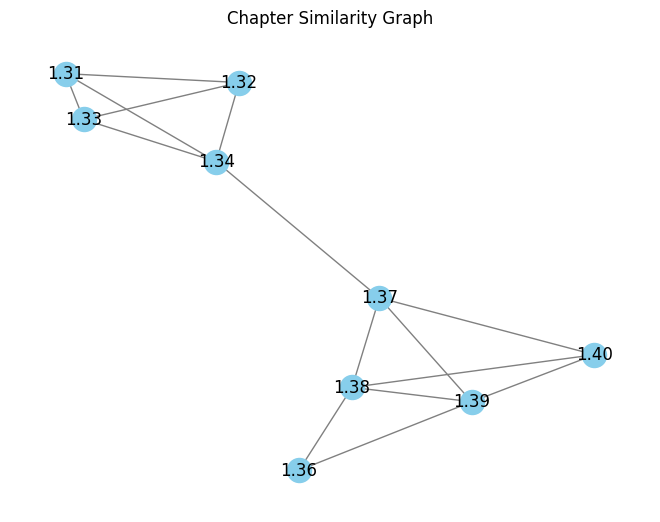

In [ ]:
import networkx as nx

G = nx.Graph()
for i in sim_df.index:
    for j in sim_df.columns:
        if i < j and sim_df.loc[i, j] > 0.3:  # threshold for "related"
            G.add_edge(i, j, weight=sim_df.loc[i, j])

pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_color='skyblue', edge_color='gray')
plt.title("Chapter Similarity Graph")
plt.show()


### Chapter sim

In [4]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity


def chapter_similarity_propagation(chapter_entities, query_entities, k=5, verbose=False):
    """
    Compute chapter relevance given entity frequencies and query entities.
    Stage 1: Direct relevance using TF-IDF
    Stage 2: Propagated relevance via similarity graph

    Args:
        chapter_entities: dict {chapter_id: {entity: frequency, ...}}
        query_entities: list of entity names (IDs)
        k: number of top chapters to use for propagation
        verbose: if True, prints intermediate details

    Returns:
        pd.Series of final propagated relevance scores (sorted descending)
    """

    # ---------- Build dense matrix ----------
    all_entities = sorted({e for ents in chapter_entities.values() for e in ents})
    df = pd.DataFrame(0, index=chapter_entities.keys(), columns=all_entities)
    for ch, ents in chapter_entities.items():
        for ent, freq in ents.items():
            df.loc[ch, ent] = freq

    df_norm = df.div(df.sum(axis=1), axis=0).fillna(0)  # divide each row by its row-sum

    tfidf = TfidfTransformer()  # disable sklearn's L2 normalization
    X_tfidf = tfidf.fit_transform(df_norm.values)

    # ---------- Stage 1: Direct relevance ----------
    query_indices = [i for i, e in enumerate(all_entities) if e in query_entities]
    if not query_indices:
        raise ValueError("None of the query entities are found in the data.")

    query_weights = np.ones(len(query_indices))
    relevance = X_tfidf[:, query_indices].dot(query_weights)
    if not isinstance(relevance, np.ndarray):
        relevance = relevance.toarray()
    relevance = np.ravel(relevance)


    # ---------- Pick top-k seed chapters ----------
    topk_idx = np.argsort(-relevance)[:k]
    topk_chapters = [df.index[i] for i in topk_idx]
    if verbose:
        print(f"Top-{k} direct chapters: {list(zip(topk_chapters, relevance[topk_idx]))}")

    # ---------- Stage 2: Propagate via similarity ----------
    sim_matrix = cosine_similarity(X_tfidf)
    prop_scores = np.zeros(len(df))
    for idx in topk_idx:
        prop_scores += relevance[idx] * sim_matrix[:, idx]

    final_scores = pd.Series(prop_scores, index=df.index).sort_values(ascending=False)

    return final_scores


In [ ]:
query_entities = ['e800', 'e801', 'e802', 'e4618', 'e4619', 'e4620', 'e4621', 'e4622', 'e300']

scores = chapter_similarity_propagation(ch_entities, query_entities, k=5, verbose=True)


Top-5 direct chapters: [('13.152', np.float64(1.9226753943919093)), ('13.73', np.float64(1.4248912069007946)), ('7.89', np.float64(1.3889063293368833)), ('12.22', np.float64(1.267238147832241)), ('13.12', np.float64(1.219675897211278))]


In [ ]:
# Normalize scores to be between 0 and 1 (Min-Max scaling)
scores_normalized = 1 / (1 + np.exp(-2*scores))

In [ ]:
scores_normalized[0:50]

,0
12.150,0.981365
12.151,0.966628
12.152,0.906621
13.23,0.648793
12.197,0.645051
13.108,0.636733
13.101,0.630393
13.162,0.630239
12.198,0.628876
12.221,0.620270


In [ ]:
print(chapters['5.105'])

Kanya said In the meantime Garuda endued with great might, heard what had happened, namely the bestowal of a long life on the Naga by Shakra, OBharata. 
And Suparna, the wanderer of the sky, obstructing the there worlds as it were by the heavy wind caused by his wings and being very, came to Vasava. 
Garuda said O lord, for what shortcoming on my part have you, forbidden me my subsistence-having granted me a boon of your own accord you have withheld it. 
Since the very creation of all creatures my food has been settled by the Supreme Being, the of all creatures and for what reason have you interfered with it. 
This great Naga had been chosen by me (for my food) and the limit of his time had been fixed by me and on him was I to have subsisted, 0 lord, as also my numerous progeny. 
I dare not now kill another of the species, which is used such (i.e., on whom you have granted a boon); you play as you like, of your own will, O king the gods. 
Reduced to this I shall lose my life as also wi

### viz

In [19]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
import matplotlib.pyplot as plt


def chapter_similarity_propagation(
    chapter_entities, query_entities, k=1, visualize=False, verbose=False, top_n_vis=15
):
    """
    Compute chapter relevance given entity frequencies and query entities.
    Stage 1: Direct relevance using TF-IDF
    Stage 2: Propagated relevance via similarity graph
    Optionally visualize the propagation.

    Args:
        chapter_entities: dict {chapter_id: {entity: frequency, ...}}
        query_entities: list of entity names (IDs)
        k: number of top chapters to use for propagation
        visualize: bool, if True draw propagation graph
        verbose: if True print intermediate info
        top_n_vis: number of top chapters to visualize

    Returns:
        pd.Series of final propagated relevance scores (sorted descending)
    """

    # ---------- Build dense matrix ----------
    all_entities = sorted({e for ents in chapter_entities.values() for e in ents})
    df = pd.DataFrame(0, index=chapter_entities.keys(), columns=all_entities)
    for ch, ents in chapter_entities.items():
        for ent, freq in ents.items():
            df.loc[ch, ent] = freq

    # ---------- Compute TF-IDF ----------
    tfidf = TfidfTransformer()
    X_tfidf = tfidf.fit_transform(df.values)

    # ---------- Stage 1: Direct relevance ----------
    query_indices = [i for i, e in enumerate(all_entities) if e in query_entities]
    if not query_indices:
        raise ValueError("None of the query entities are found in the data.")

    query_weights = np.ones(len(query_indices))
    relevance = X_tfidf[:, query_indices].dot(query_weights)
    if not isinstance(relevance, np.ndarray):
        relevance = relevance.toarray()
    relevance = np.ravel(relevance)

    # ---------- Pick top-k seed chapters ----------
    topk_idx = np.argsort(-relevance)[:k]
    topk_chapters = [df.index[i] for i in topk_idx]
    if verbose:
        print(f"Top-{k} direct chapters: {list(zip(topk_chapters, relevance[topk_idx]))}")

    # ---------- Stage 2: Propagate via similarity ----------
    sim_matrix = cosine_similarity(X_tfidf)
    prop_scores = np.zeros(len(df))
    for idx in topk_idx:
        prop_scores += relevance[idx] * sim_matrix[:, idx]

    final_scores = pd.Series(prop_scores, index=df.index).sort_values(ascending=False)

    # ---------- Optional visualization ----------
    if visualize:
        G = nx.Graph()

        # Add edges from top-k seeds to their most influenced chapters
        for i in topk_idx:
            ch_i = df.index[i]
            influences = relevance[i] * sim_matrix[:, i]
            # take strongest neighbors for visibility
            top_j_idx = np.argsort(-influences)[:top_n_vis]
            for j in top_j_idx:
                ch_j = df.index[j]
                if ch_i != ch_j and influences[j] > 0:
                    G.add_edge(ch_i, ch_j, weight=influences[j])

        pos = nx.spring_layout(G, seed=42)
        edge_weights = [d['weight'] for _, _, d in G.edges(data=True)]
        node_colors = ['skyblue' if n in topk_chapters else 'lightgray' for n in G.nodes]

        plt.figure(figsize=(8, 7))
        nx.draw_networkx(
            G,
            pos,
            with_labels=True,
            node_size=1000,
            node_color=node_colors,
            width=[3 * (w / max(edge_weights)) for w in edge_weights],
            edge_color="gray",
            font_size=10,
        )
        plt.title("Propagation of Relevance Across Chapters")
        plt.show()

    return final_scores


In [17]:
entities_kb['e3660']

{'key': 'drOpadI',
 'description': "Draupadī, the wife of the Pāṇḍavas (her proper name was Kṛṣṇā (K; as daughter of the Pāñcāla king Drupada she was named Draupadī, Pāñcālī (P, Pārṣatī (Pār, and Yājñasenī (Y. , [ (K, (K)], [ (K)]. , [ (P)]. , [ (P, (K)], °yās tanayān, [ (P, (K)], [ (P)], [ (P)], [ (K)], (all. to foll. , ( Kṛṣṇā. , [ (K, all to)], ( Pāñcālyāṃ, mother of five sons: Prativindhya from Yudhiṣṭhira, Sutasoma from Bhīmasena, Śrutakīrti from Arjuna, Śatānīka from Nakula, and Śrutasena from Sahadeva. , (born from a portion of Śacī. , †† (wife of the Pāṇḍavas, mother of Prativindhya, Sutasoma, Śrutakīrti, Śatānīka, and Śrutakarman. , [ ( Yājñasenyāḥ svayāṃvaraṃ, ( ayonijatvaṃ Kṛṣṇāyā Drupadasya mahāmakhe, all. to, ( vedīmadhyāc ca Kṛṣṇāyāḥ sambhavaḥ, all. to)], ( °sambhavaṃ—[, (P, (K, (origin of the name Kṛṣṇā: kṛṣṇā bhūtā hi varṇataḥ. arose from the centre of the vedī at the sacrifice of Drupada.]—[, (K, Pār, in a former existence. five times had asked Śiva for a husband, ther

Top-1 direct chapters: [('3.28', np.float64(1.4050870631886698))]


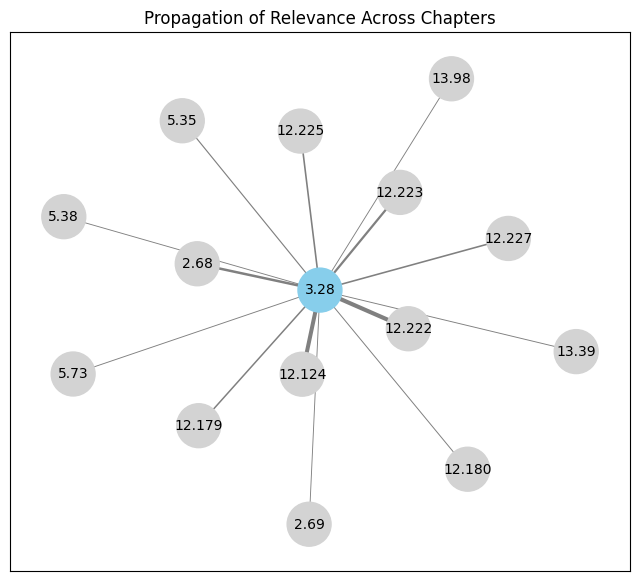

In [22]:
query_entities = ['e8487', 'e1197', 'e3660', 'e12633']


scores = chapter_similarity_propagation(ch_entities, query_entities, k=1, visualize = True, verbose=True)


In [ ]:
entities_kb['e4787']

{'key': 'janamejaya',
 'description': "Janamejaya, pl. ( °āḥ. , (eighty J.'s in the palace of Yama",
 'cleaned_description': 'Janamejaya is a name. There are eighty Janamejayas in the palace of Yama.',
 'aliases': [],
 'cluster_head': True}

### Debug and build

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity


def build_entity_matrix(ch_entities):
    """Create normalized entity frequency matrix (chapters × entities)."""
    all_entities = sorted({e for ents in ch_entities.values() for e in ents})
    df = pd.DataFrame(0, index=ch_entities.keys(), columns=all_entities)

    for ch, ents in ch_entities.items():
        for ent, freq in ents.items():
            df.loc[ch, ent] = freq

    # Normalize per chapter (term frequency normalization)
    df_norm = df.div(df.sum(axis=1), axis=0).fillna(0)
    return df, df_norm, all_entities

df, df_norm, all_entities = build_entity_matrix(ch_entities)

In [ ]:
def compute_tfidf(df_norm):
    """Compute TF-IDF matrix from normalized entity frequencies."""
    tfidf = TfidfTransformer(norm=None)
    X_tfidf = tfidf.fit_transform(df_norm.values)
    return X_tfidf


def get_valid_query_indices(query_entities, query_weights, all_entities):
    """Return indices and weights of query entities that exist in the corpus."""
    valid_pairs = [
        (all_entities.index(e), w)
        for e, w in zip(query_entities, query_weights)
        if e in all_entities
    ]
    if not valid_pairs:
        return None, None
    query_indices, valid_weights = zip(*valid_pairs)
    return list(query_indices), np.array(valid_weights)

def group_consecutive_entities(entities):
    groups = []
    current_group = [entities[0]]

    for prev, curr in zip(entities, entities[1:]):
        if int(curr[1:]) == int(prev[1:]) + 1:  # check consecutive numbers
            current_group.append(curr)
        else:
            groups.append(current_group)
            current_group = [curr]
    groups.append(current_group)
    return groups

def compute_group_mask(df, groups):
    """
    Return a binary mask [num_chapters x num_groups]
    where mask[i, g] = 1 if chapter i contains any entity from group g.
    """
    mask = np.zeros((len(df), len(groups)), dtype=int)
    for g_idx, group in enumerate(groups):
        valid_entities = [e for e in group if e in df.columns]
        mask[:, g_idx] = (df[valid_entities].sum(axis=1) > 0).astype(int)
    return mask


def compute_direct_relevance(X_tfidf, query_indices, query_weights):
    """Compute direct relevance of each chapter using weighted query entities."""
    # Step 1: compute normal relevance
    relevance = np.ravel(X_tfidf[:, query_indices].dot(query_weights))

    # Step 2: build group mask
    groups = group_consecutive_entities(query_entities)
    group_mask = compute_group_mask(df, groups)

    # Step 3: find which chapters have all groups represented
    has_all_groups = (group_mask.sum(axis=1) == len(groups))

    # Step 4: zero out relevance for chapters missing a group
    group_coverage = group_mask.sum(axis=1) / len(groups)
    relevance = relevance * group_coverage

    if not isinstance(relevance, np.ndarray):
        relevance = relevance.toarray()
    return np.ravel(relevance)


def propagate_relevance(X_tfidf, df, query_entities, relevance, k=5):
    """Propagate relevance scores through similarity graph (masked)."""
    sim_matrix = cosine_similarity(X_tfidf)
    topk_idx = np.argsort(-relevance)[:k]
    prop_scores = np.zeros(len(df))

    # Mask: chapters that contain at least one query entity
    valid_cols = [e for e in query_entities if e in df.columns]
    chapter_mask = (df[valid_cols].sum(axis=1) > 0).astype(int).values

    for idx in topk_idx:
        masked_sim = sim_matrix[:, idx] * chapter_mask
        prop_scores += relevance[idx] * masked_sim

    return prop_scores


def normalize_scores(prop_scores, alpha=2.0):
    """Apply sigmoid normalization to propagated scores."""
    return 1 / (1 + np.exp(-alpha * (prop_scores - np.mean(prop_scores))))

def chapter_similarity_propagation(chapter_entities, query_entities, query_weights, k=5, alpha=2.0):
    """
    Compute chapter relevance given entity frequencies and query entities.
    Stage 1: Direct relevance using TF-IDF
    Stage 2: Propagated relevance via similarity graph (masked)
    """

    # Stage 1: TF-IDF
    X_tfidf = compute_tfidf(df_norm)

    # Stage 1.5: Query entity matching
    query_indices, query_weights = get_valid_query_indices(query_entities, query_weights, all_entities)
    # print(query_indices, query_weights)
    if query_indices is None:
        zero_scores = pd.Series(0.0, index=df.index)
        return [], zero_scores.to_dict()

    # Stage 2: Direct relevance
    relevance = compute_direct_relevance(X_tfidf, query_indices, query_weights)


    # Stage 3: Propagation
    prop_scores = propagate_relevance(X_tfidf, df, query_entities, relevance, k=k)

    # Stage 4: Normalization
    scores_normalized = normalize_scores(prop_scores, alpha=alpha)

    # Stage 5: Output
    final_scores = pd.Series(scores_normalized, index=df.index).sort_values(ascending=False)
    top3_ids = list(final_scores.index[:3])
    return top3_ids, final_scores.to_dict()


In [ ]:
query_entities = ['e800', 'e801', 'e802', 'e4618', 'e4619', 'e4620', 'e4621', 'e4622', 'e300']

query_weights = [93.33333333333333, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]
chapter_similarity_propagation(ch_entities, query_entities, query_weights)

(['15.38', '16.5', '1.1'],
 {'15.38': 1.0,
  '16.5': 1.0,
  '1.1': 1.0,
  '1.2': 1.0,
  '16.6': 1.0,
  '7.152': 1.0,
  '7.126': 1.0,
  '7.128': 1.0,
  '7.129': 1.0,
  '7.130': 1.0,
  '7.131': 1.0,
  '7.135': 1.0,
  '14.91': 1.0,
  '15.10': 1.0,
  '15.11': 1.0,
  '15.12': 1.0,
  '15.13': 1.0,
  '15.15': 1.0,
  '15.17': 1.0,
  '7.139': 1.0,
  '7.140': 1.0,
  '7.141': 1.0,
  '7.110': 1.0,
  '7.111': 1.0,
  '7.112': 1.0,
  '7.119': 1.0,
  '14.81': 1.0,
  '14.82': 1.0,
  '14.83': 1.0,
  '14.84': 1.0,
  '14.85': 1.0,
  '14.86': 1.0,
  '14.87': 1.0,
  '7.124': 1.0,
  '7.94': 1.0,
  '7.99': 1.0,
  '7.100': 1.0,
  '7.101': 1.0,
  '7.102': 1.0,
  '7.103': 1.0,
  '7.104': 1.0,
  '7.105': 1.0,
  '14.79': 1.0,
  '14.80': 1.0,
  '1.61': 1.0,
  '7.78': 1.0,
  '7.79': 1.0,
  '7.80': 1.0,
  '7.81': 1.0,
  '7.83': 1.0,
  '7.84': 1.0,
  '7.85': 1.0,
  '7.88': 1.0,
  '7.89': 1.0,
  '7.90': 1.0,
  '7.91': 1.0,
  '7.92': 1.0,
  '14.67': 1.0,
  '14.72': 1.0,
  '14.73': 1.0,
  '14.74': 1.0,
  '14.75': 1.0,
  

In [ ]:
query_indices, _query_weights = get_valid_query_indices(query_entities, query_weights, all_entities)
X_tfidf = compute_tfidf(df_norm)
relevance = compute_direct_relevance(X_tfidf, query_indices, _query_weights)

In [ ]:
top_ranked = np.argsort(-relevance)  # descending order
top_ids = [df.index[i] for i in top_ranked[:10]]  # top 10 chapters
for a, b in zip(top_ids, top_ranked[:10]):
  print(a,b)

7.89 1106
12.22 1448
4.48 677
4.63 692
3.301 615
14.74 2032
8.18 1238
3.44 358
14.76 2034
7.28 1045


In [ ]:
chapter_entities['12.22']

{'e11327-person--vaishampayana': 1,
 'e801-person--arjuna': 1,
 'e1741-person--brahman': 1,
 'e4618-person--indra': 3}

In [ ]:
chapters['12.22']

"After this, Arjuna again said to his eldest brother of unfading glory, king Yudhishthira of cheerless heart : \n'O you who are conversant with every kind of duty, having by the practise of Kshatriya duties acquired sovereignty that is so very difficult of acquisition, and having defeated all your foes, why do you grieve. \nO king, as regards Kshatriyas, death in battle is regarded more meritorious for them than the celebration of various sacrifices. it is so laid down in the ordinance that describes the duties of Kshatriyas. \nPenances and Renunciation constitute the duties of Brahmanas. Such is also the ordinance about the next world, Indeed, O powerful one, death in battle is laid down for Kshatriyas. \nThe duties of Kshatriyas are highly dreadful and are always connected with the use of weapons, and it has been ordained, O chief of the Bharatas, that they should, when the time comes, die by weapons on the field of battle. \nThe life of even a Brahmana, O king, who follows the obser

In [ ]:
entities_kb['e300']

{'key': 'Endra',
 'description': '*Aindra, adj. (“belonging to or named after Indra”, ( muhūrte. Yudhiṣṭhira, ( Aindram astram employed by Bhīma, ( Aindraṃ padaṃ.e. the sovereignty over the gods, ( Aindrīṃ sabhāṃ, ( Aindro rājanya ucyate, ( Aindro dharmaḥ kṣattriyāṇām brāhmaṇāṇām athāgnikaḥ, ( sthānāt, ( vajraṃ, ( diśaṃ, ( padaṃ, ( sthanat, (do, ( Aindrīṃ sandhyāṃ —the morning twilight: by worshipping it with the face directed towards the East one has bathed in all the tīrthas and becomes purified from all sins— sarvatīrtheṣu sa snāto mucyate sarva- kilviṣaiḥ, † ( vākyaṃ',
 'cleaned_description': '*Aindra*, adj. ("belonging to or named after Indra"):  - It describes *muhūrte* (moment) in relation to Yudhiṣṭhira.  - It refers to *Aindram astram* (Indra\'s weapon) employed by Bhīma.  - It denotes *Aindraṃ padaṃ* (the sovereignty over the gods).  - It mentions *Aindrīṃ sabhāṃ* (Indra\'s assembly).  - It states *Aindro rājanya ucyate* (the royal class is called Indra\'s).  - It defines *Ai